## <center>Bank of England Spot Exchange Rates, Euro into USD</center>
#### <center>(Data Source: Quandl)</center>

<img src="https://media.licdn.com/mpr/mpr/jc/AAEAAQAAAAAAAAa6AAAAJDU0ZjBjZmRhLWM2OTMtNDgxMy05NjlkLTAwYzcxZjdiZjFkMg.png" width="200" height="200" />

## <center>Using ARIMA forecasting on Spot Exchange Rates from 1976 to Present</center>

### Import necessary libraries

In [1]:
import requests, StringIO, pandas as pd, json, re, numpy as np
from sklearn import preprocessing
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer
from sklearn.preprocessing import Imputer
from pyspark.sql import SQLContext, Row
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from pyspark.ml.feature import RFormula
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
import time
from datetime import date
from dateutil import parser
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pylab as plt
from io import BytesIO
import json
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

### Read data into Pandas dataframe

In [2]:
# The code was removed by DSX for sharing.

,Date,Value
0,2016-11-04,0.8992
1,2016-11-03,0.9012
2,2016-11-02,0.8994
3,2016-11-01,0.9056
4,2016-10-31,0.9122


### Set datetime index for the dataframe

In [3]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])

In [4]:
indexed_df = df_fx_data.set_index('Date')

In [5]:
indexed_df.index

DatetimeIndex(['2016-11-04', '2016-11-03', '2016-11-02', '2016-11-01',
               '2016-10-31', '2016-10-28', '2016-10-27', '2016-10-26',
               '2016-10-25', '2016-10-24',
               ...
               '1975-01-15', '1975-01-14', '1975-01-13', '1975-01-10',
               '1975-01-09', '1975-01-08', '1975-01-07', '1975-01-06',
               '1975-01-03', '1975-01-02'],
              dtype='datetime64[ns]', name=u'Date', length=10581, freq=None)

In [6]:
ts = indexed_df['Value']

In [7]:
ts.head(5)

Date
2016-11-04    0.8992
2016-11-03    0.9012
2016-11-02    0.8994
2016-11-01    0.9056
2016-10-31    0.9122
Name: Value, dtype: float64

In [8]:
ts_month = ts.resample('M').mean()

### Plot time series for Euro into USD values

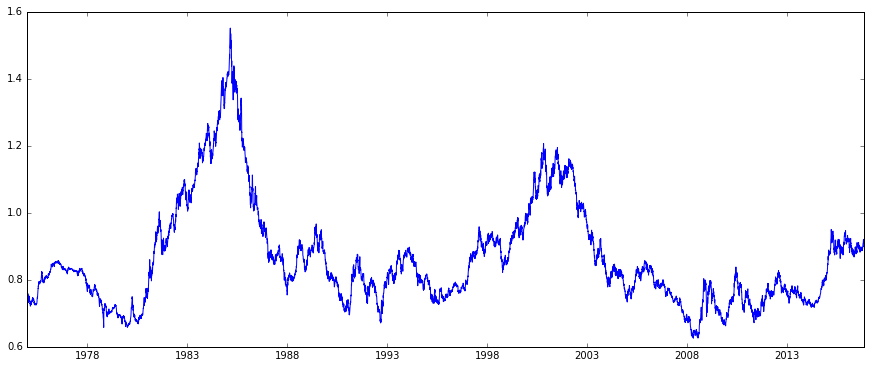

In [19]:
plt.plot(ts)

### Check Stationarity of time series

In [27]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

### The Dickey-Fuller test results show that the time series in non-stationary at non-significant p-value and varying mean and standard deviation

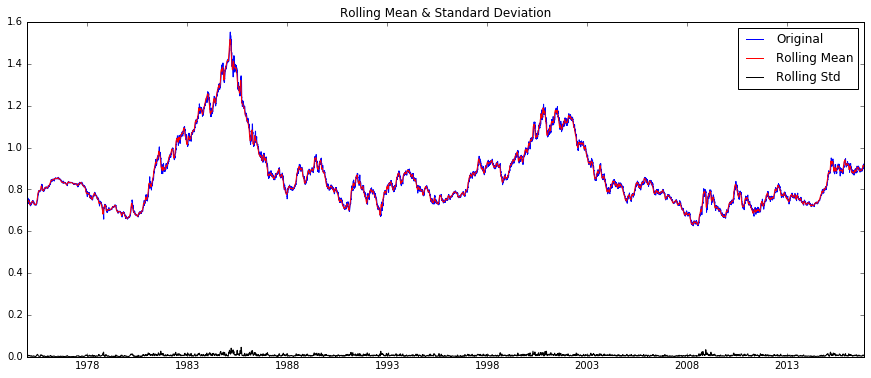

Results of Dickey-Fuller Test:
Test Statistic                    -2.023326
p-value                            0.276440
#Lags Used                        21.000000
Number of Observations Used    10559.000000
Critical Value (5%)               -2.861814
Critical Value (1%)               -3.430969
Critical Value (10%)              -2.566916
dtype: float64


In [28]:
test_stationarity(ts)

### Now that we have confirmed the time series is non-stationary, let's take the necessary steps to make it stationary. This will allow us to use forecasting algorithms to predict future exchange rates

### Estimating and eliminating trend that contributes to variance in the mean and standard deviation

### Taking a log transform to reduce trend

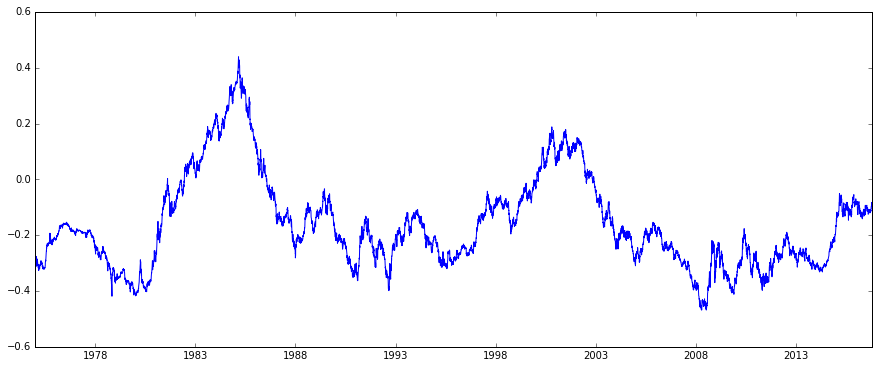

In [29]:
ts_log = np.log(ts)
plt.plot(ts_log)

### Changing frequency of time series to monthly for better smoothing

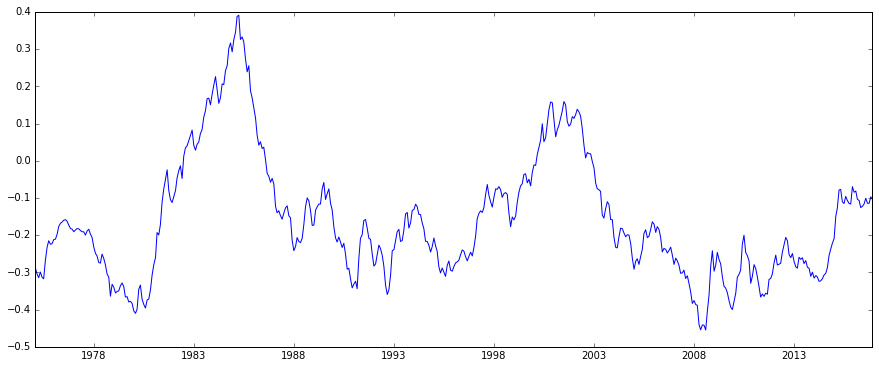

In [82]:
ts_log_month = np.log(ts_month)
plt.plot(ts_log_month)

### Smoothing technique using moving average to eliminate trend

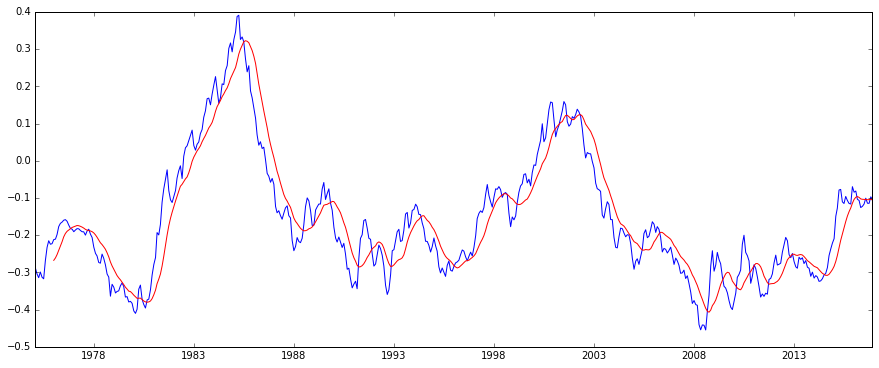

In [102]:
moving_avg = ts_log_month.rolling(window=12,center=False).mean()
plt.plot(ts_log_month)
plt.plot(moving_avg, color='red')

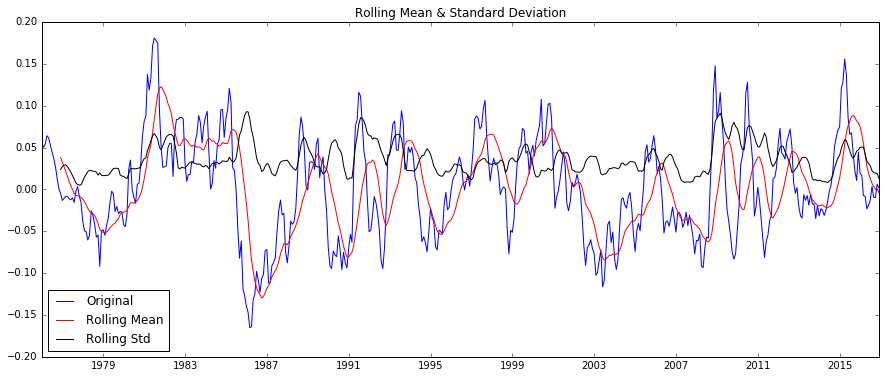

Results of Dickey-Fuller Test:
Test Statistic                -5.951497e+00
p-value                        2.141863e-07
#Lags Used                     3.000000e+00
Number of Observations Used    4.880000e+02
Critical Value (5%)           -2.867481e+00
Critical Value (1%)           -3.443821e+00
Critical Value (10%)          -2.569934e+00
dtype: float64


In [103]:
ts_log_month_moving_avg_diff = ts_log_month - moving_avg
ts_log_month_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_month_moving_avg_diff)

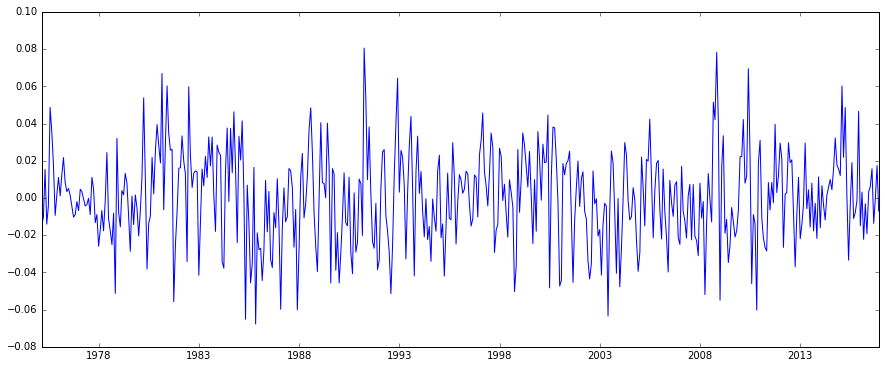

In [83]:
ts_log_month_diff = ts_log_month - ts_log_month.shift()
plt.plot(ts_log_month_diff)

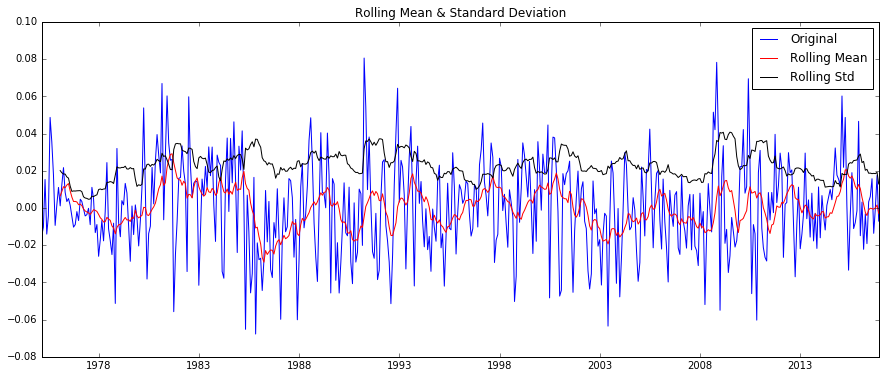

Results of Dickey-Fuller Test:
Test Statistic                -1.102394e+01
p-value                        5.892220e-20
#Lags Used                     2.000000e+00
Number of Observations Used    4.990000e+02
Critical Value (5%)           -2.867350e+00
Critical Value (1%)           -3.443523e+00
Critical Value (10%)          -2.569864e+00
dtype: float64


In [87]:
ts_log_month_diff.dropna(inplace=True)
test_stationarity(ts_log_month_diff)

### This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. This means taking the first logged difference of the time series gives us a stationary series

### Now that we have obtained stationary time series, lets use ARIMA model to forecast exchange rates

### Let's use the auto-correlation and partial auto-correlation functions to determine order of the AR & MA terms

In [43]:
#ACF and PACF plots

In [104]:
lag_acf = acf(ts_log_month_diff, nlags=10)
lag_pacf = pacf(ts_log_month_diff, nlags=10, method='ols')

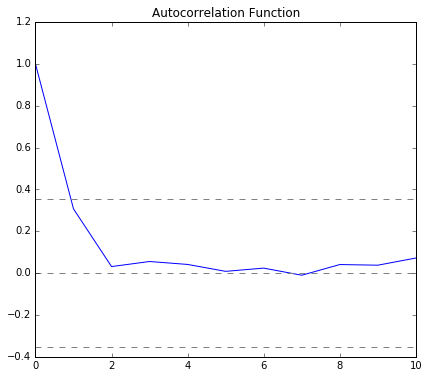

In [105]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_month_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_month_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

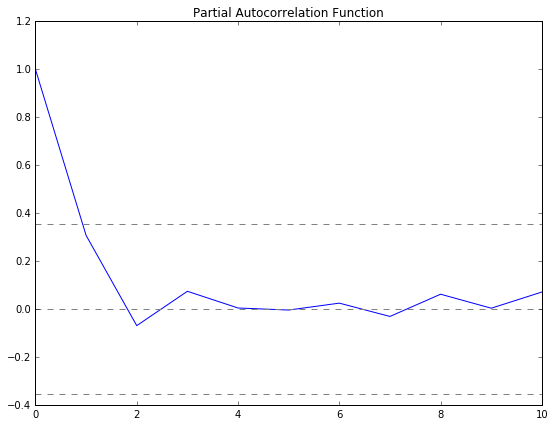

In [106]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_month_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_month_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

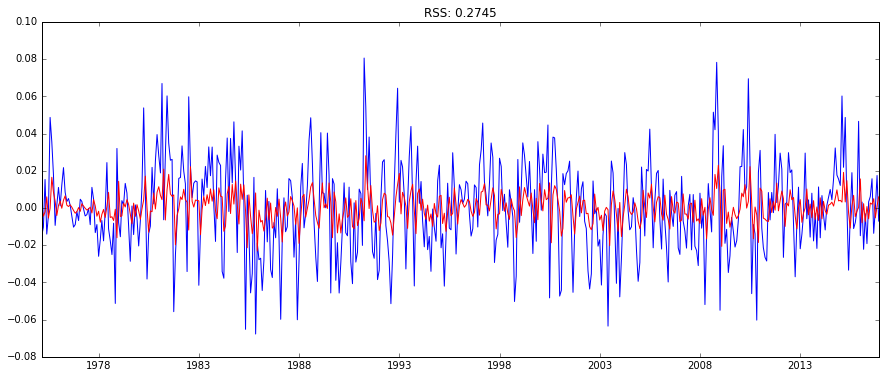

In [99]:
model = ARIMA(ts_log_month, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_month_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_month_diff)**2))

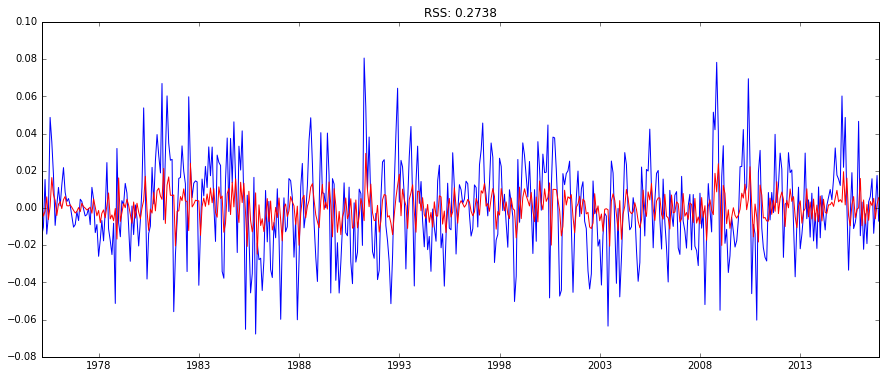

In [101]:
model = ARIMA(ts_log_month, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_month_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_month_diff)**2))

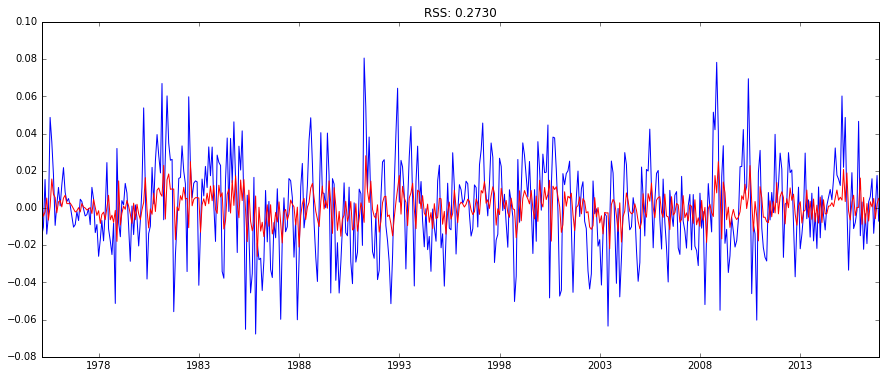

In [98]:
model = ARIMA(ts_log_month, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_month_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_month_diff)**2))

In [94]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Date
1975-02-28    0.000359
1975-03-31   -0.004392
1975-04-30   -0.002079
1975-05-31    0.005349
1975-06-30   -0.006498
Freq: M, dtype: float64


In [95]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Date
1975-02-28    0.000359
1975-03-31   -0.004033
1975-04-30   -0.006112
1975-05-31   -0.000763
1975-06-30   -0.007261
Freq: M, dtype: float64


In [96]:
predictions_ARIMA_log = pd.Series(ts_log_month.ix[0], index=ts_log_month.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1975-01-31   -0.288840
1975-02-28   -0.288482
1975-03-31   -0.292874
1975-04-30   -0.294952
1975-05-31   -0.289603
Freq: M, dtype: float64

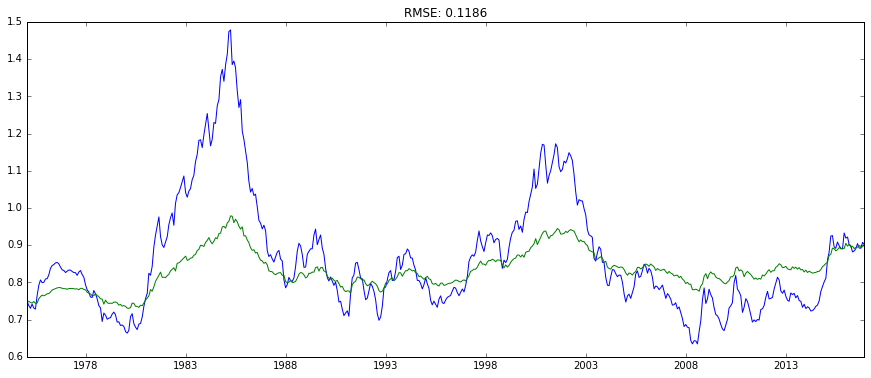

In [100]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_month)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_month)**2)/len(ts_month)))

### Lets load and analyze twitter sentiment data around Euro currency and determine if it had impact on its conversion rate to USD

In [9]:
props = {}
props['user'] = 'dash014603'
props['password'] = 'M2Yn7Y4wrZOl'
jdbcurl = 'jdbc:db2://bluemix05.bluforcloud.com:50000/BLUDB'
table_name1 = 'EURO_CURRENCY_TWEETS'
table_name2 = 'EURO_CURRENCY_SENTIMENTS'
euro_curr_tweets = sqlContext.read.jdbc(jdbcurl, table_name1, properties=props)
euro_curr_sentiments = sqlContext.read.jdbc(jdbcurl, table_name2, properties=props)
euro_curr_tweets.printSchema()

root
 |-- MESSAGE_ID: string (nullable = true)
 |-- MESSAGE_BODY: string (nullable = true)
 |-- MESSAGE_FAVORITES_COUNT: integer (nullable = true)
 |-- MESSAGE_INREPLYTO_URL: string (nullable = true)
 |-- MESSAGE_URL: string (nullable = true)
 |-- MESSAGE_POSTED_TIME: timestamp (nullable = true)
 |-- MESSAGE_RETWEET_COUNT: integer (nullable = true)
 |-- MESSAGE_LANGUAGE: string (nullable = true)
 |-- MESSAGE_ACTION: string (nullable = true)
 |-- MESSAGE_GENERATOR_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_COUNTRY: string (nullable = true)
 |-- MESSAGE_LOCATION_DISPLAY_NAME: string (nullable = true)
 |-- MESSAGE_LOCATION: string (nullable = true)
 |-- MESSAGE_COUNTRY_CODE: string (nullable = true)
 |-- USER_ID: string (nullable = true)
 |-- USER_GENDER: string (nullable = true)
 |-- USER_DISPLAY_NAME: string (nullable = true)
 |-- USER_FAVORITES_COUNT: integer (nullable = true)
 |-- USER_FOLLOWERS_COUNT: integer (nullable = true)
 |-- USER_FRIENDS_COUNT: integer (nullable = tru

In [197]:
#euro_curr_tweets.take(5)

#### You can't analyze the data that you have just loaded into the data frames the way it is. To be able to consume this data, it must first be prepared and transformed.

#### The output of the data transformation process is a new Spark DataFrame which has the target structure on which to base the data analysis. This Spark DataFrame called df_cleaned_tweets functions as the main data source for all further processing.

#### Run the next cell to carry out the following transformations on the data:
#### 1) Remove the time from the timestamp values as only the date information is relevant.
#### 2) Change the values in the string columns like user country, state and city to uppercase.
#### 3) Change the tweet posting location information from a string ('pos (42.000 42.000)') to a numeric value represented by the longitude and latitude coordinates.

#### You will use the resulting DataFrame (df_cleaned_tweets) as the base data source for all further step.

#### The sample uses Spark to do all heavy computation. When it is time to plot or collect the results, the returned data is moved from a Spark DataFrame to a pandas DataFrame. A pandas DataFrame is a flexible data structure for data analysis and plotting.

In [12]:
def getLongitudeLatitude(position):
    parts = str(position).split('(')[1].split(')')[0].split(' ')
    return parts

def getLongitude(row):
    if ((row.MESSAGE_LOCATION is None)):
        return None
    else:
        parts = getLongitudeLatitude(row.MESSAGE_LOCATION)
        lon = float(parts[0])
        return lon

def getLatitude(row):
    if ((row.MESSAGE_LOCATION is None)):
        return None
    else:
        parts = getLongitudeLatitude(row.MESSAGE_LOCATION)
        lon = float(parts[1])
        return lon

def getDateIgnoreTime(row):
    posting_time = parser.parse(str(row.MESSAGE_POSTED_TIME))
    posting_time = posting_time.replace(hour=0, minute=0, second=0, microsecond=0)
    return posting_time

In [13]:
df_cleaned_tweets = sqlContext.createDataFrame(euro_curr_tweets.map(lambda row: [row.MESSAGE_ID,
                        getDateIgnoreTime(row),
                        row.MESSAGE_BODY,
                        row.USER_GENDER,
                        unicode(row.USER_STATE).upper(),
                        unicode(row.USER_COUNTRY).upper(),
                        unicode(row.USER_CITY).upper(),
                        row.MESSAGE_LANGUAGE,
                        row.USER_FOLLOWERS_COUNT,
                        row.USER_FRIENDS_COUNT
                    ]),
                    ['MESSAGE_ID',
                     'POSTING_TIME',
                     'MESSAGE_BODY',
                     'USER_GENDER',
                     'USER_STATE',
                     'USER_COUNTRY',
                     'USER_CITY',
                     'MESSAGE_LANGUAGE',
                     'USER_FOLLOWERS_COUNT',
                     'USER_FRIENDS_COUNT'
                    ])

In [14]:
df_cleaned_senti = sqlContext.createDataFrame(euro_curr_sentiments.map(lambda row: [row.MESSAGE_ID,
                        unicode(row.SENTIMENT_POLARITY).upper(),
                        unicode(row.SENTIMENT_TERM).upper()
                    ]),
                    ['MESSAGE_ID',
                     'SENTIMENT_POLARITY',
                     'SENTIMENT_TERM'
                    ])

In [15]:
from pyspark.sql.functions import *
df_cleaned_tweets.registerTempTable('EURO_TWEETS_CLEANED')
df_cleaned_tweets = df_cleaned_tweets.select(
  year('POSTING_TIME').alias('year'),
  month('POSTING_TIME').alias('month'),
  df_cleaned_tweets.MESSAGE_BODY)
df_cleaned_tweets.cache()
#df_cleaned_tweets.printSchema()

DataFrame[year: int, month: int, MESSAGE_BODY: string]

In [16]:
df_cleaned_senti.registerTempTable('EURO_SENTIMENTS_CLEANED')
df_cleaned_senti.cache()
#df_cleaned_senti.printSchema()

DataFrame[MESSAGE_ID: string, SENTIMENT_POLARITY: string, SENTIMENT_TERM: string]

In [17]:
#group by year
df_cleaned_tweets_year = df_cleaned_tweets.groupBy('year','month')\
                                .agg(F.count('MESSAGE_BODY').alias('NUM_TWEETS'))\
                                .orderBy('NUM_TWEETS', ascending=False)
df_cleaned_tweets_year.cache()
df_cleaned_tweets_year.show(5)

+----+-----+----------+
|year|month|NUM_TWEETS|
+----+-----+----------+
|2016|    7|       228|
|2015|    7|       223|
|2016|    6|       197|
|2015|    6|       192|
|2015|    1|       146|
+----+-----+----------+
only showing top 5 rows



In [18]:
df_joined = sqlContext.sql("select t.*, s.* from EURO_TWEETS_CLEANED t join EURO_SENTIMENTS_CLEANED s on t.MESSAGE_ID = s.MESSAGE_ID")
df_joined.cache()
#df_joined.printSchema()

DataFrame[MESSAGE_ID: string, POSTING_TIME: timestamp, MESSAGE_BODY: string, USER_GENDER: string, USER_STATE: string, USER_COUNTRY: string, USER_CITY: string, MESSAGE_LANGUAGE: string, USER_FOLLOWERS_COUNT: bigint, USER_FRIENDS_COUNT: bigint, MESSAGE_ID: string, SENTIMENT_POLARITY: string, SENTIMENT_TERM: string]

In [19]:
df_pos_tweets_year = df_joined.filter("SENTIMENT_POLARITY = 'POSITIVE'")\
                                .groupBy(year('POSTING_TIME').alias('POSTING_TIME_YEAR'))\
                                .agg(F.count('MESSAGE_BODY').alias('NUM_POS_TWEETS'))\
                                .orderBy('NUM_POS_TWEETS', ascending=False)

df_pos_tweets_year.cache()
df_pos_tweets_year.show(5)

+-----------------+--------------+
|POSTING_TIME_YEAR|NUM_POS_TWEETS|
+-----------------+--------------+
|             2015|           272|
|             2016|           237|
|             2014|            79|
+-----------------+--------------+



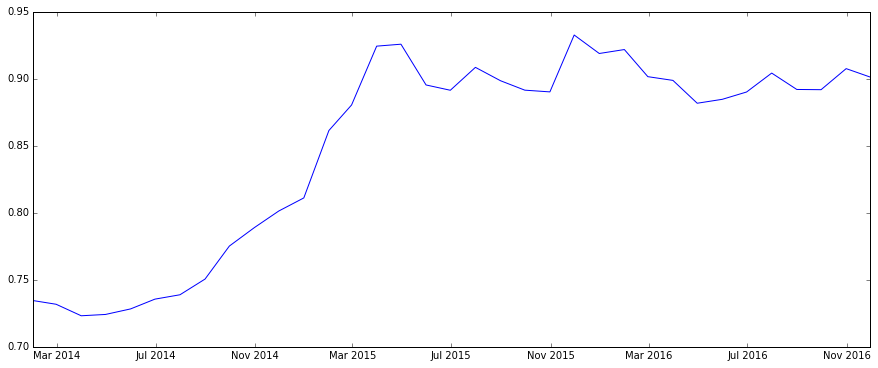

In [215]:
ts_month_adv = ts_month[ts_month.index >= '2014-01-31']
plt.plot(ts_month_adv)

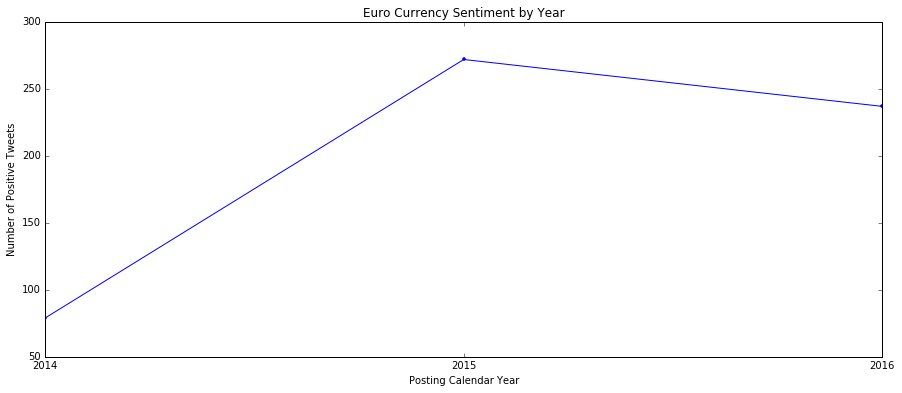

In [41]:
df_pos_tweets_year_pd = df_pos_tweets_year.toPandas()
df_pos_tweets_year_pd = df_pos_tweets_year_pd.sort_values(['POSTING_TIME_YEAR'])  # dict doesn't preserve order

x = df_pos_tweets_year_pd['POSTING_TIME_YEAR']
y = df_pos_tweets_year_pd['NUM_POS_TWEETS']
labels = ['2014','2015','2016']

plt.plot(x, y, marker='.')
plt.xticks(x, labels)
plt.xlabel("Posting Calendar Year")
plt.ylabel("Number of Positive Tweets")
plt.title("Euro Currency Sentiment by Year")
